In [123]:
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt
import scipy.stats as sps

# Deuxième cas : Méthode delta :

$ I_0=10, \alpha_i=10, \beta_i=5 $

## Préliminaire :

Paramètres de la simulation :

In [124]:
T0,T,Y=120,10,252

alpha=1-1e-5
I0=10
sigma = np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]) #yearly std
S0=np.array([500,400,300,200,100,50,40,30,20,10])
K=np.array([510,390,310,190,90,55,35,34,17,12])
n=2*int(1e4)

coeffC=np.zeros(I0)+10
coeffP=np.zeros(I0)+5

In [125]:
def d1(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) + sig*np.sqrt(to)/2
def d2(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) - sig*np.sqrt(to)/2


def callPrice(S,t,K,sigma,T):
    return S*sps.norm.cdf(d1((T-t)/Y,S,K,sigma))-K*sps.norm.cdf(d2((T-t)/Y,S,K,sigma))
def putPrice(S,t,K,sigma,T):
    return K*sps.norm.cdf(d1((T-t)/Y,K,S,sigma))-S*sps.norm.cdf(d2((T-t)/Y,K,S,sigma))

In [126]:
def dCall(S,t,K,sigma,T):
  return sps.norm.cdf(d1((T-t)/Y,S,K,sigma))+sps.norm.pdf(d1((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d2((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedCallPrice(S,t,K,sigma,T,S0):
  return callPrice(S,t,K,sigma,T)-dCall(S0,0,K,sigma,T)*S

def dPut(S,t,K,sigma,T):
  return -sps.norm.cdf(d2((T-t)/Y,K,S,sigma))+sps.norm.pdf(d2((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d1((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedPutPrice(S,t,K,sigma,T,S0):
  return putPrice(S,t,K,sigma,T)-dPut(S0,0,K,sigma,T)*S

Définition des Greeks du modèle de Black-Scholes :

In [127]:
#Greeks
#for a call:
def thetaC(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaC(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,S0,K,sigma))
def gammaC(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))

#for a put:
def thetaP(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaP(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,K,S0,sigma))-1
def gammaP(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))


On définit deux quantités : $\delta$ et $\Theta$, avec $\delta$ défini pour le cas hedgé et non hedgé:

In [128]:
C=np.diag(sigma*np.sqrt(T/Y)*S0)
delta=coeffC*deltaC(S0,K,sigma,T,T0)+coeffP*deltaP(S0,K,sigma,T,T0)
deltaH=delta-coeffC*dCall(S0,0,K,sigma,T0)-coeffP*dPut(S0,0,K,sigma,T0)
Theta=np.dot(coeffC.T,thetaC(S0,K,sigma,T,T0))+np.dot(coeffP.T,thetaP(S0,K,sigma,T,T0))

Deux méthodes pour calculer des estimations grossières de la VaR utiliser ci-dessous:

In [129]:
def estimVaR(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C.T,delta))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

def estimVaRHedged(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C,deltaH))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

Pour exploiter la force d'optimisation de numpy, on définit les matrices suivantes: (éviter les boucles for):

In [130]:
Si=np.zeros((n,I0))
MatSigma=np.zeros((n,I0))
MatK=np.zeros((n,I0)) 
for i in range(I0):
  Si[:,i]+=S0[i]
  MatK[:,i]+=K[i]
  MatSigma[:,i]+=sigma[i]

## Cas Indépendant:

On utilise $logIncr$ comme incrément de la chaîne de Markov.

$logIncr \sim \mathcal N(\mu,\Sigma)$
 avec 
 $$\Sigma =
\begin{pmatrix}
\sigma_{1}^{2} & 0 & \cdots & 0 \\
0 & \sigma_{2}^{2} & \cdots & \vdots \\
\vdots  & \vdots  & \ddots & 0  \\
0 &  \cdots & 0 & \sigma_{I_{0}}^{2}
\end{pmatrix}
$$ et $$\mu= \frac{-1}{2}\begin{pmatrix}
\sigma_{1}^{2} \\
\sigma_{2}^{2}  \\
\vdots   \\
\sigma_{I_{0}}^{2}
\end{pmatrix}$$

In [131]:
roughEstimVaR= estimVaR(np.eye(I0))
roughEstimVaRHedged=estimVaRHedged(np.eye(I0))

print(roughEstimVaR,roughEstimVaRHedged)

357.42733444577016 168.09812303847636


In [132]:
a=-Theta*T/Y
L=np.eye(I0)
CovSqrt=np.dot(C,L)
b=-np.dot(CovSqrt.T,delta)

### Cas non-hedgé:

#### Estimation de la VaR et la CVaR

[-1.25124857 -2.35235276 -1.7116603  -2.13169205 -1.4377814  -0.48791859
 -0.79181013 -0.48039593 -0.6241769  -0.25218015]


(array([5.000e+00, 1.800e+01, 8.800e+01, 2.990e+02, 9.970e+02, 2.598e+03,
        4.943e+03, 6.395e+03, 4.103e+03, 5.540e+02]),
 array([-59.72556434, -25.04021464,   9.64513506,  44.33048476,
         79.01583446, 113.70118416, 148.38653386, 183.07188356,
        217.75723326, 252.44258296, 287.12793266]),
 <a list of 10 Patch objects>)

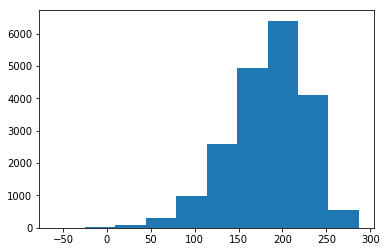

In [133]:
mu=(roughEstimVaR-a)*b/np.sum(b*b)
print(mu)

Z=np.random.normal(size=(I0,n))
for i in range(I0):
  Z[i,:]=mu[i]+Z[i,:]
  

dS=np.dot(CovSqrt,Z)
Sf=Si+dS.T

calls=callPrice(Sf,T,K,sigma,T0)
puts=putPrice(Sf,T,K,sigma,T0)


callInitial=callPrice(Si,0,K,sigma,T0)
putInitial=putPrice(Si,0,K,sigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
sortedLoss=np.sort(loss)
plt.hist(loss)

0.4939971472038707
19203
248.81924380629047 254.99659927264662


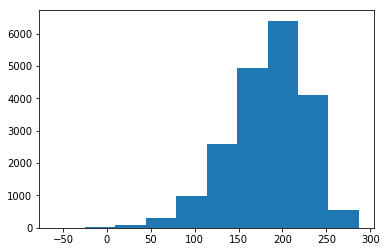

In [134]:
A=np.zeros((n,2))

r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))

A[:,0],A[:,1]=loss,r

print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0]) #on prend les indices pour lesquelles le vecteur A[:,0]=pertes sera ordonné

A=A[indexes,:] #on ordonne notre vecteur 2d selon la première composante

k,sum=n-1,0
while(sum+A[k,1]/n <1-alpha):
  sum,k=sum+A[k,1]/n,k-1

print(k) #Number of observations below VaR

VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

#### Convergence des estimateurs :

Cette partie de code a été commenté parce qu'elle prend beaucoup de temps à s'executer. Une deuxième version avec un tri par insertion avec une complexité de $O(nlog(n)) $ .

In [135]:
'''
VaRvalues=[]
ESvalues=[]
A=np.zeros((n,2))
A[:,0],A[:,1]=loss,r
for i in range(10,n,10):
  B=A[:i,:i]
  indexes=np.argsort(B[:,0])

  B=B[indexes,:]
  k,sum=i-1,0
  while(sum+B[k,1]/i <1-alpha):
    sum,k=sum+B[k,1]/i,k-1

  VaRvalues.append(B[k,0])
  ES=np.sum(B[k+1:,0]*B[k+1:,1])/i + (1-alpha-np.sum(B[k+1:,1])/i)*B[k,0]
  ESvalues.append(ES/(1-alpha))
  '''
#Very time consuming methode to show convergence

'\nVaRvalues=[]\nESvalues=[]\nA=np.zeros((n,2))\nA[:,0],A[:,1]=loss,r\nfor i in range(10,n,10):\n  B=A[:i,:i]\n  indexes=np.argsort(B[:,0])\n\n  B=B[indexes,:]\n  k,sum=i-1,0\n  while(sum+B[k,1]/i <1-alpha):\n    sum,k=sum+B[k,1]/i,k-1\n\n  VaRvalues.append(B[k,0])\n  ES=np.sum(B[k+1:,0]*B[k+1:,1])/i + (1-alpha-np.sum(B[k+1:,1])/i)*B[k,0]\n  ESvalues.append(ES/(1-alpha))\n  '

In [136]:
#plt.subplot(2,1,1)
#plt.plot(np.arange(10,n,10),VaRvalues,label="Convergence du quantile empirique")

#plt.subplot(2,1,2)
#plt.plot(np.arange(10,n,10),ESvalues,label="Convergence de la CVaR")
#plt.legend(loc='best')

#### Distribution au delà de la $VaR$

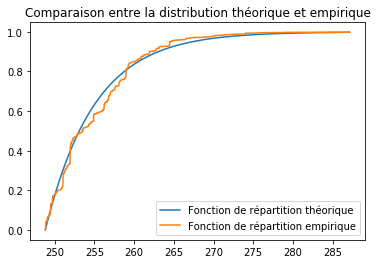

In [137]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) #1/lambda

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

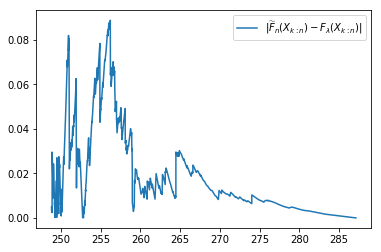

In [138]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

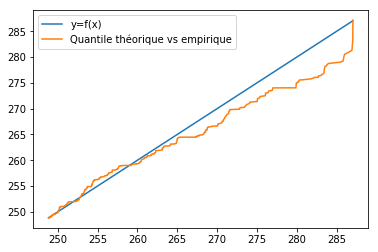

In [139]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

#### Intervalle de confiance

In [140]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,I0)) 
    dS=np.dot(CovSqrt,Z.T)
    Sf=Si+dS.T
    
    calls=callPrice(Sf,T,MatK,MatSigma,T0)
    puts=putPrice(Sf,T,MatK,MatSigma,T0)

    callInitial=callPrice(Si,0,MatK,MatSigma,T0)
    putInitial=putPrice(Si,0,MatK,MatSigma,T0)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90


In [141]:
#Methode delta


VaR,CVaR=[],[]

for i in range(m):
    mu=(roughEstimVaR-a)*b/np.sum(b*b)

    Z=np.random.normal(size=(I0,n))
    for j in range(I0):
      Z[j,:]=mu[j]+Z[j,:]

    dS=np.dot(CovSqrt,Z)
    Sf=Si+dS.T

    calls=callPrice(Sf,T,K,sigma,T0)
    puts=putPrice(Sf,T,K,sigma,T0)


    callInitial=callPrice(Si,0,K,sigma,T0)
    putInitial=putPrice(Si,0,K,sigma,T0)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90


{'whiskers': [<matplotlib.lines.Line2D at 0x1ca45ed7e48>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca45ee37f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca45ed7cf8>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca45ee3e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca45eeb550>,
 'means': [<matplotlib.lines.Line2D at 0x1ca45ee3f60>,
  <matplotlib.lines.Line2D at 0x1ca45ef3c88>]}

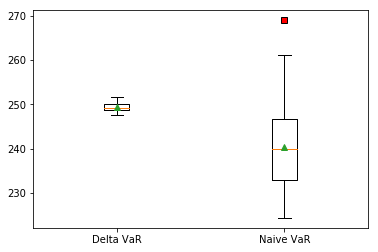

In [142]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta VaR','Naive VaR'))

On trouve un intervalle de confiance très précis.

{'whiskers': [<matplotlib.lines.Line2D at 0x1ca45f447f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca45f44e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca45f443c8>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca45f4b550>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca45f4bbe0>,
 'means': [<matplotlib.lines.Line2D at 0x1ca45f4b898>,
  <matplotlib.lines.Line2D at 0x1ca45f64358>]}

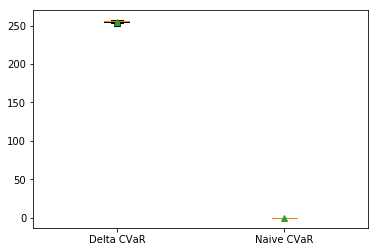

In [143]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta CVaR','Naive CVaR'))


Dans le cas naif on a une unique observations.

### Cas Hedgé:

#### Estimation de la VaR et la CVaR

In [144]:
mu=(roughEstimVaRHedged-a)*b/np.sum(b*b)

Z=np.random.normal(size=(I0,n))
for i in range(I0):
    Z[i,:]=mu[i]+Z[i,:]

dS=np.dot(CovSqrt,Z)
Sf=Si+dS.T

(array([1.000e+00, 0.000e+00, 9.000e+00, 4.100e+01, 1.440e+02, 5.230e+02,
        1.806e+03, 4.733e+03, 8.581e+03, 4.162e+03]),
 array([-353.25928989, -312.89280238, -272.52631487, -232.15982736,
        -191.79333985, -151.42685234, -111.06036483,  -70.69387732,
         -30.32738981,   10.0390977 ,   50.40558521]),
 <a list of 10 Patch objects>)

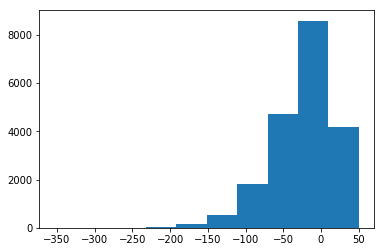

In [145]:
calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [146]:
A=np.zeros((n,2))

r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0

while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1

print(k) #number of observation below VaR
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

0.9868577065633586
19999
50.405585208470015 50.405585208470015


#### Distribution au delà de la $VaR$

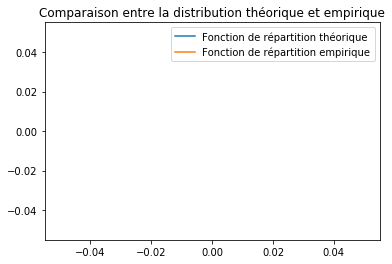

In [147]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

<h3>Remarque </h3>

Aucune observation ne vérifie la condition X>VaR même après l'échantillonnage d'importance

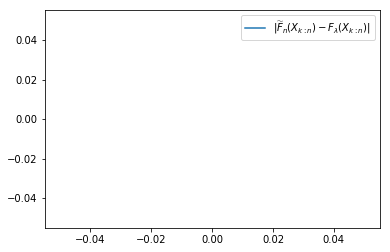

In [148]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

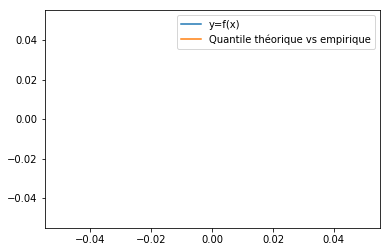

In [149]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

#### Intervalle de confiance :

In [150]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(I0,n))
    
    dS=np.dot(CovSqrt,Z)
    Sf=Si+dS.T
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90


In [151]:
#Methode delta

VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(I0,n))
    for j in range(I0):
        Z[j,:]=mu[j]+Z[j,:]

    dS=np.dot(CovSqrt,Z)
    Sf=Si+dS.T

    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90


{'whiskers': [<matplotlib.lines.Line2D at 0x1ca44083630>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca44083cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca44083208>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca4408c390>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca4408ca20>,
 'means': [<matplotlib.lines.Line2D at 0x1ca4408c6d8>,
  <matplotlib.lines.Line2D at 0x1ca44b9bef0>]}

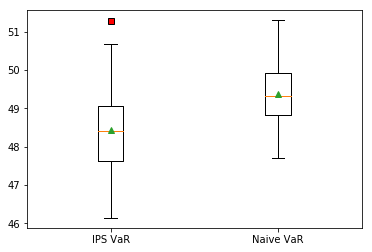

In [152]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta VaR','Naive VaR'))

{'whiskers': [<matplotlib.lines.Line2D at 0x1ca44102e80>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca4410a828>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca44102d30>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca4410aeb8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca41756588>,
 'means': [<matplotlib.lines.Line2D at 0x1ca4410af98>,
  <matplotlib.lines.Line2D at 0x1ca4175fcc0>]}

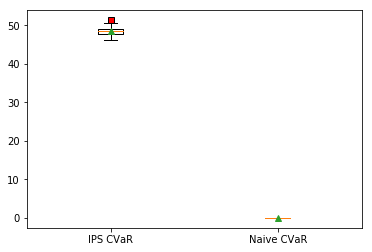

In [153]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta CVaR','Naive CVaR'))


<h3>Conclusion partielle :</h3>
La méthode Delta qui consiste à changer la moyenne de la gaussienne $Z$, a amélioré l'estimation dans le cas non couvert, mais a été sans effet dans le cas couvert.


# Cas Dépendant:

 On multiplie la matrice initiale $\Sigma$ par la matrice $M$ des deux côtés et on obtient une nouvelle matrice de covariance $M^T \Sigma M$ où M est défini de la facon suivante :
 $$M =
\begin{pmatrix}
1 & \rho & \cdots & \rho \\
\rho & 1 & \cdots & \vdots \\
\vdots  & \vdots  & \ddots &\rho  \\
\rho &  \cdots & \rho & 1
\end{pmatrix}
$$

In [154]:
rho=0.1
Cov=(1-rho)*np.eye(I0)+rho*np.ones((I0,I0)) 
L = lin.cholesky(Cov, lower=True)

In [155]:
roughEstimVaR= estimVaR(L)
roughEstimVaRHedged=estimVaRHedged(L)

print(roughEstimVaR,roughEstimVaRHedged)

441.54680983707533 163.3069135242055


In [156]:
a=-Theta*T/Y
L=np.eye(I0)
CovSqrt=np.dot(C,L)
b=-np.dot(CovSqrt.T,delta)

## Cas Non Hedgé:

In [157]:
mu=(roughEstimVaR-a)*b/np.sum(b*b)
print(mu)

Z=np.random.normal(size=(I0,n))
for i in range(I0):
  Z[i,:]=mu[i]+Z[i,:]

dS=np.dot(CovSqrt,Z)
Sf=Si+dS.T

calls=callPrice(Sf,T,K,sigma,T0)
puts=putPrice(Sf,T,K,sigma,T0)


callInitial=callPrice(Si,0,K,sigma,T0)
putInitial=putPrice(Si,0,K,sigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)

[-1.59737029 -3.0030631  -2.1851416  -2.72136298 -1.83550203 -0.62288715
 -1.01084149 -0.61328356 -0.79683738 -0.32193849]


(array([2.000e+00, 3.000e+00, 4.000e+01, 1.300e+02, 5.830e+02, 1.768e+03,
        4.280e+03, 6.690e+03, 5.414e+03, 1.090e+03]),
 array([-111.89827143,  -72.20819002,  -32.5181086 ,    7.17197282,
          46.86205424,   86.55213565,  126.24221707,  165.93229849,
         205.6223799 ,  245.31246132,  285.00254274]),
 <a list of 10 Patch objects>)

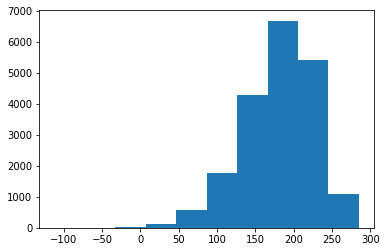

In [158]:
calls=callPrice(Sf,T,MatK,MatSigma,T0)
puts=putPrice(Sf,T,MatK,MatSigma,T0)

callInitial=callPrice(Si,0,MatK,MatSigma,T0)
putInitial=putPrice(Si,0,MatK,MatSigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

0.16290945450178912
18869
244.71050977119233 252.4334998340142


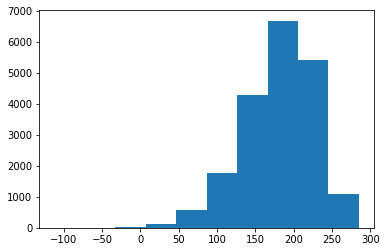

In [159]:
A=np.zeros((n,2))

r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]
k=n-1
sum=0
while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1
print(k)
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

### Distribution au delà de la VaR:

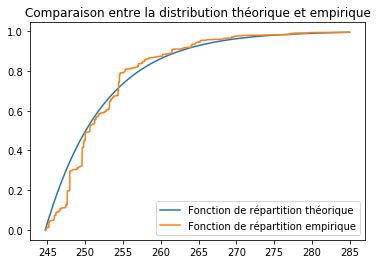

In [160]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

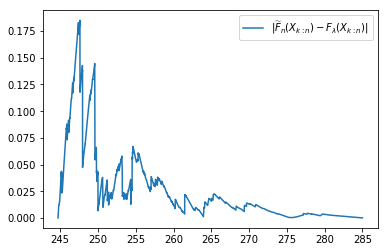

In [161]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

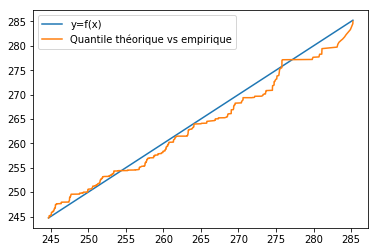

In [162]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

### Intervalle de confiance :

In [163]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,I0)) 
    
    dS=np.dot(CovSqrt,Z.T)
    Sf=Si+dS.T
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90


In [164]:
#Méthode delta


VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(I0,n))
    for i in range(I0):
      Z[i,:]=mu[i]+Z[i,:]

    dS=np.dot(CovSqrt,Z)
    Sf=Si+dS.T
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ca4188cf98>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca41881668>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca4188cb70>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca41881cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca418933c8>,
 'means': [<matplotlib.lines.Line2D at 0x1ca41881dd8>,
  <matplotlib.lines.Line2D at 0x1ca4189eb00>]}

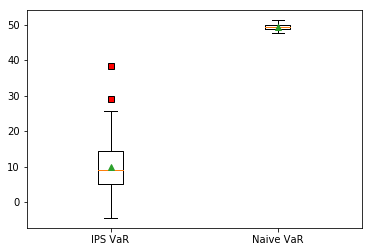

In [165]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta VaR','Naive VaR'))

{'whiskers': [<matplotlib.lines.Line2D at 0x1ca45ff1470>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca45ff1b00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca45ff1048>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca45ff1f28>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca45ffb860>,
 'means': [<matplotlib.lines.Line2D at 0x1ca45ffb518>,
  <matplotlib.lines.Line2D at 0x1ca46005f98>]}

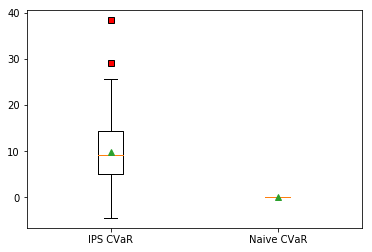

In [166]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta CVaR','Naive CVaR'))


## Cas hedgé :

In [167]:
b=-np.dot(CovSqrt.T,deltaH)
mu=(roughEstimVaRHedged-a)*b/np.sum(b*b)
print(mu)

Z=np.random.normal(size=(I0,n))
for i in range(I0):
  Z[i,:]=mu[i]+Z[i,:]

dS=np.dot(CovSqrt,Z)
Sf=Si+dS.T

[-1.65657521  1.73785813 -1.63051406  1.75812881  1.74802249 -0.77218736
  0.89115189 -0.59876799  0.55129057 -0.28258229]


(array([6.000e+00, 1.300e+01, 7.100e+01, 3.260e+02, 1.026e+03, 2.821e+03,
        5.184e+03, 6.235e+03, 3.769e+03, 5.490e+02]),
 array([-453.38340115, -404.56036527, -355.73732939, -306.91429352,
        -258.09125764, -209.26822176, -160.44518588, -111.62215001,
         -62.79911413,  -13.97607825,   34.84695763]),
 <a list of 10 Patch objects>)

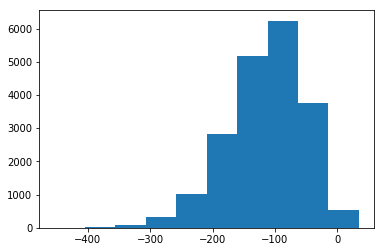

In [168]:
calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [169]:
A=np.zeros((n,2))
r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0

while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1

print(k) #number of observation below VaR
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

1.0302037012139198
19999
34.84695762538897 34.84695762538897


### Distribution au delà de la $Var$

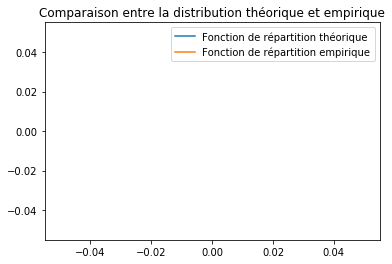

In [170]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

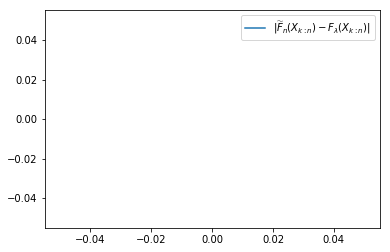

In [171]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

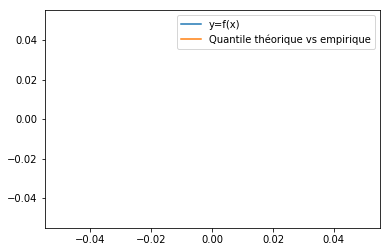

In [172]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

### Intervalle de confiance:

In [173]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,I0)) 
    dS=np.dot(CovSqrt,Z.T)
    Sf=Si+dS.T
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90


In [174]:
#Methode delta
la=roughEstimVaR/(T+1)
VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(I0,n)) 
    for i in range(I0):
      Z[i,:]=mu[i]+Z[i,:]

    dS=np.dot(CovSqrt,Z)
    Sf=Si+dS.T
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    r=np.exp(0.5*np.dot(mu.T,mu)-np.dot(mu.T,Z))
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ca44985e48>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca44610518>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca44985a20>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca44610ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca44610f98>,
 'means': [<matplotlib.lines.Line2D at 0x1ca44610ef0>,
  <matplotlib.lines.Line2D at 0x1ca446259b0>]}

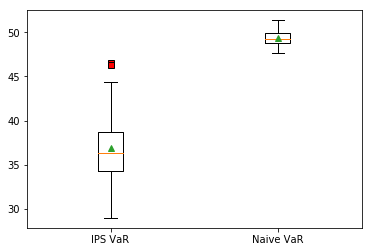

In [175]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta VaR','Naive VaR'))

{'whiskers': [<matplotlib.lines.Line2D at 0x1ca4466cfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ca44676978>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ca4466ce80>,
 'medians': [<matplotlib.lines.Line2D at 0x1ca44676da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ca446826d8>,
 'means': [<matplotlib.lines.Line2D at 0x1ca44682390>,
  <matplotlib.lines.Line2D at 0x1ca4468de10>]}

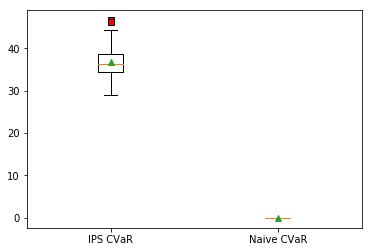

In [176]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('Delta CVaR','Naive CVaR'))
